# ⚛️ H₂ VarQITE — **Noiseless** (Pure Package Client)

This notebook runs **Variational Quantum Imaginary-Time Evolution (VarQITE)** for **H₂**
using only the packaged API:

```python
from qite.core import run_qite
```

It mirrors the VQE/QPE notebook ergonomics:
- **Cached** runs persisted by the package I/O utilities
- **Plots** saved via the package plotting utilities
- A quick **cache check** by rerunning with `force=False`

---

## What we compute
- Molecule: **H₂** (STO-3G, registry geometry)
- Ansatz: **UCCSD**
- Method: **VarQITE (McLachlan, tangent-space projected)**

Outputs (from `run_qite`):
- `"energy"` and `"energies"` (convergence)
- `"final_state_real"`, `"final_state_imag"` (final statevector components)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qite.core import run_qite
from qite.io_utils import ensure_dirs

ensure_dirs()

In [2]:
molecule_name = "H2"
seed = 0

ansatz = "UCCSD"

steps = 75
dtau = 0.1

# VarQITE numerics
fd_eps = 1e-3
reg = 1e-6
solver = "solve"
pinv_rcond = 1e-10


⚙️ Using VarQITE (McLachlan) update rule
Iter 01/75: E = 0.919629 Ha
Iter 02/75: E = 0.919479 Ha
Iter 03/75: E = 0.919281 Ha
Iter 04/75: E = 0.919019 Ha
Iter 05/75: E = 0.918673 Ha
Iter 06/75: E = 0.918214 Ha
Iter 07/75: E = 0.917604 Ha
Iter 08/75: E = 0.916793 Ha
Iter 09/75: E = 0.915713 Ha
Iter 10/75: E = 0.914272 Ha
Iter 11/75: E = 0.912346 Ha
Iter 12/75: E = 0.909768 Ha
Iter 13/75: E = 0.906312 Ha
Iter 14/75: E = 0.901675 Ha
Iter 15/75: E = 0.895448 Ha
Iter 16/75: E = 0.887084 Ha
Iter 17/75: E = 0.875857 Ha
Iter 18/75: E = 0.860810 Ha
Iter 19/75: E = 0.840706 Ha
Iter 20/75: E = 0.813975 Ha
Iter 21/75: E = 0.778693 Ha
Iter 22/75: E = 0.732614 Ha
Iter 23/75: E = 0.673307 Ha
Iter 24/75: E = 0.598467 Ha
Iter 25/75: E = 0.506454 Ha
Iter 26/75: E = 0.397050 Ha
Iter 27/75: E = 0.272253 Ha
Iter 28/75: E = 0.136708 Ha
Iter 29/75: E = -0.002750 Ha
Iter 30/75: E = -0.138642 Ha
Iter 31/75: E = -0.264863 Ha
Iter 32/75: E = -0.378047 Ha
Iter 33/75: E = -0.477593 Ha
Iter 34/75: E = -0.564641 Ha


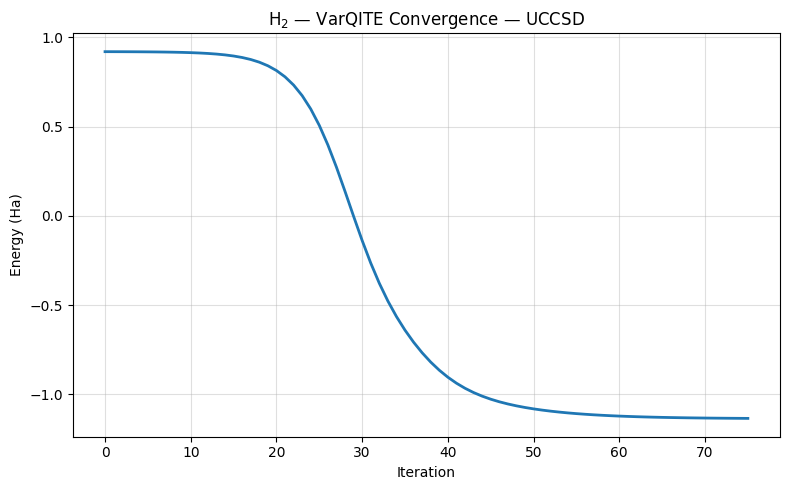

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qite/H2/convergence_UCCSD_s0.png

💾 Saved run record: varqite__H2__UCCSD__jordan_wigner__noiseless__steps75__dtau0p1__s0__3632340576c0.json


✅ VarQITE run complete.
Final energy: -1.13518924 Ha
Iterations (including initial point): 76
Number of qubits: 4


In [3]:
result = run_qite(
    molecule=molecule_name,
    seed=int(seed),
    steps=int(steps),
    dtau=float(dtau),
    ansatz_name=ansatz,
    noisy=False,
    plot=True,
    show=True,
    force=False,
    # VarQITE numerics (part of cache key)
    fd_eps=float(fd_eps),
    reg=float(reg),
    solver=str(solver),
    pinv_rcond=float(pinv_rcond),
)

energies = result["energies"]
final_energy = float(result["energy"])
num_qubits = int(result["num_qubits"])

print("\n✅ VarQITE run complete.")
print(f"Final energy: {final_energy:.8f} Ha")
print(f"Iterations (including initial point): {len(energies)}")
print(f"Number of qubits: {num_qubits}")

# 🔍 Final State Reconstruction

We reconstruct the final statevector
$$
|\psi\rangle = \sum_i c_i |i\rangle
$$
from the stored real/imag parts and print only basis states with $|c_i| > 10^{-2}$.

In [4]:
psi_r = np.array(result["final_state_real"], dtype=float)
psi_i = np.array(result["final_state_imag"], dtype=float)
psi = psi_r + 1j * psi_i

threshold = 1e-2
idx = np.where(np.abs(psi) > threshold)[0]

terms = []
for i in idx:
    amp = psi[i]
    bitstr = f"|{i:0{num_qubits}b}⟩"
    if abs(amp.imag) < 1e-8:
        amp_str = f"{amp.real:.6f}"
    else:
        amp_str = f"({amp.real:.6f}{amp.imag:+.6f}j)"
    terms.append(f"{amp_str}{bitstr}")

print(f"\nSignificant components (|cᵢ| > {threshold:g}):")
if terms:
    print(" |ψ⟩ ≈ " + " + ".join(terms))
else:
    print(" (none above threshold)")


Significant components (|cᵢ| > 0.01):
 |ψ⟩ ≈ (-0.112208+0.004470j)|0011⟩ + (0.035409-0.001229j)|0110⟩ + (0.031608-0.001188j)|1001⟩ + (0.991239-0.039469j)|1100⟩ + (0.029773-0.001395j)|1101⟩ + (0.010931-0.000306j)|1110⟩


# 📊 Amplitude Magnitudes (Significant Components)

A quick bar plot of $|c_i|$ for the significant basis states.

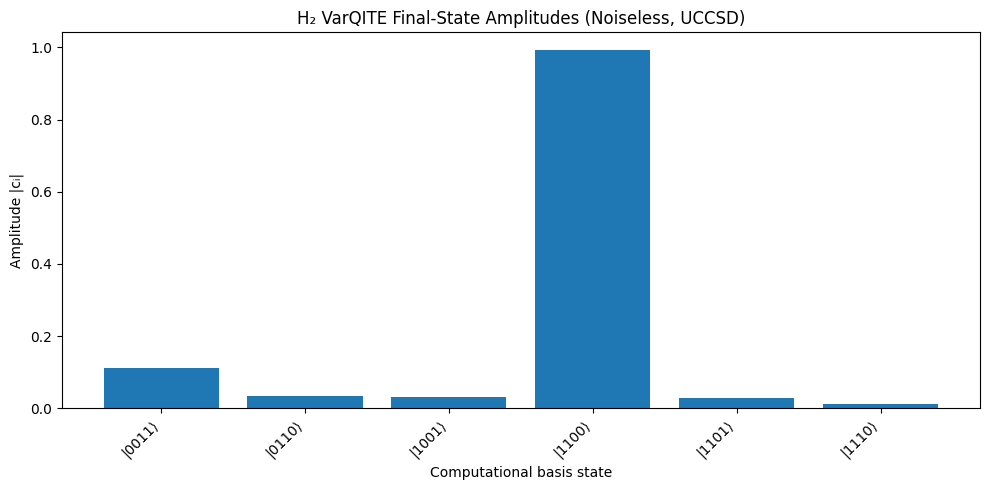

In [5]:
labels = [f"|{i:0{num_qubits}b}⟩" for i in idx]
mags = np.abs(psi[idx])

plt.figure(figsize=(10, 5))
plt.bar(labels, mags)
plt.xlabel("Computational basis state")
plt.ylabel("Amplitude |cᵢ|")
plt.title("H₂ VarQITE Final-State Amplitudes (Noiseless, UCCSD)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()